## Notebook to develop supervised classification algorithm for identifying snow in PlanetScope 4-band imagery
Rainey Aberle

Adapted from the [SciKit Learn Classifier comparison tutorial](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

### Initial setup

In [2]:
# -----Import packages
import os
import glob
import numpy as np
import rasterio as rio
import geopandas as gpd
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn import metrics 
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
import pickle

In [3]:
# -----Determine whether to save outputs to file
save_outputs = True # = True to save output figures and best classifier 

# -----Define site ID used to identify classifier output
site_ID = 'WG'

# -----Define paths in directory
# base directory (path to planet-snow/)
base_path = '/Users/raineyaberle/Research/PhD/planet-snow/'
# image directory
im_path = base_path+'../study-sites/Wolverine/imagery/Planet/adjusted-filtered/'
# output folder for best classifier
out_path = base_path+'inputs-outputs/'
# output folder for figures
figures_out_path = base_path+'figures/classifiers/'

# -----Add path to functions
sys.path.insert(1, base_path+'functions/')
from classification_utils import crop_images_to_AOI, classify_image, calculate_SCA

### Load images and snow/non-snow classified points

Image 1 CRS: EPSG:32606
Snow points 1 CRS: epsg:32606
Non-snow points 1 CRS: epsg:32606
Image 2 CRS: EPSG:32606
Snow points 2 CRS: epsg:32606
Non-snow points 2 CRS: epsg:32606


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


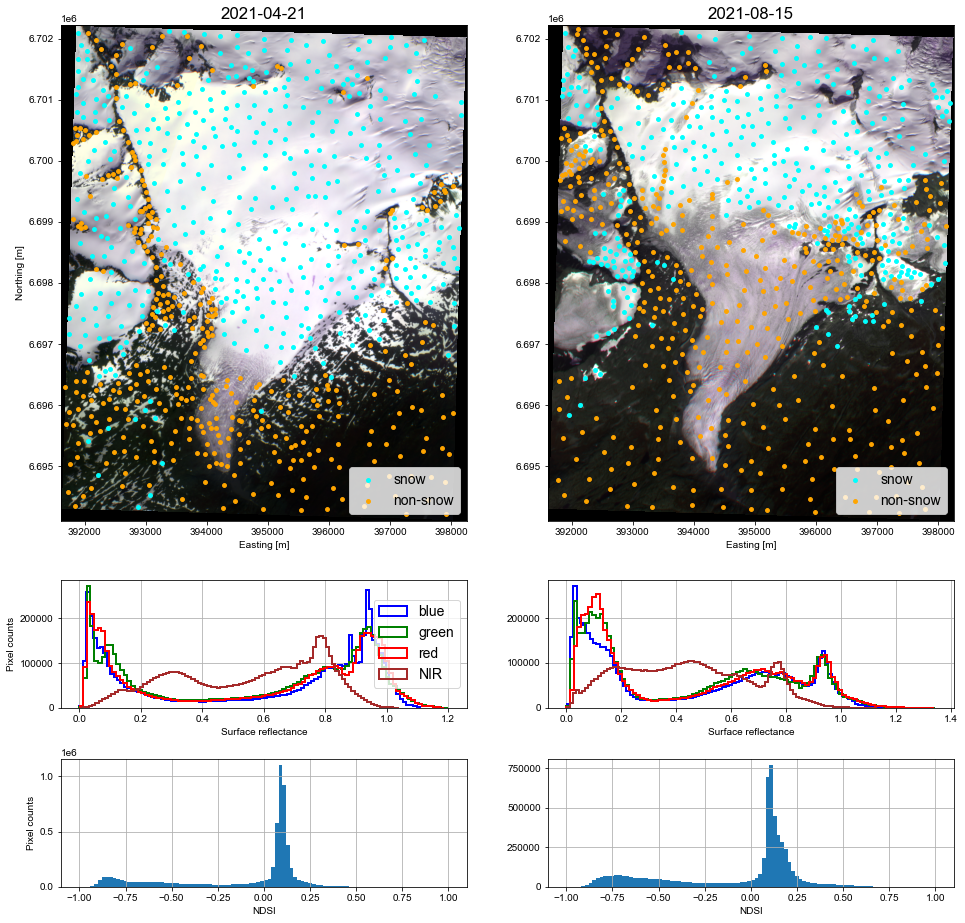

figure saved to file


In [3]:
# -----Define EPSG code
epsg = 32606

# -----Image 1
# load image
im1_fn = '20190626_21_adj.tif'
im1 = rio.open(im_path+im1_fn)
# read bands
b1 = im1.read(1).astype(float) 
r1 = im1.read(2).astype(float) 
g1 = im1.read(3).astype(float) 
nir1 = im1.read(4).astype(float) 
if np.nanmean(b1) > 1e3:
    im_scalar = 10000
    b1 = b1 / im_scalar
    g1 = g1 / im_scalar
    r1 = r1 / im_scalar
    nir1 = nir1 / im_scalar
ndsi1 = (r1 - nir1) / (r1 + nir1)
# define coordinates grid
im1_x = np.linspace(im1.bounds.left, im1.bounds.right, num=np.shape(b1)[1])
im1_y = np.linspace(im1.bounds.top, im1.bounds.bottom, num=np.shape(b1)[0])
print('Image 1 CRS:',im1.crs)
# load snow training points
data_snow_pts1_fn = base_path+'../study-sites/Wolverine/classified-points/snow_pts_20190626_21.shp'
data_snow_pts1 = gpd.read_file(data_snow_pts1_fn)
# reproject to defined CRS
data_snow_pts1 = data_snow_pts1.to_crs(epsg)
print('Snow points 1 CRS:', data_snow_pts1.crs)
# load non-snow points
data_non_snow_pts1_fn = base_path+'../study-sites/Wolverine/classified-points/non_snow_pts_20190626_21.shp'
data_non_snow_pts1 = gpd.read_file(data_non_snow_pts1_fn)
# Reproject to defined CRS
data_non_snow_pts1 = data_non_snow_pts1.to_crs(epsg)
print('Non-snow points 1 CRS:', data_non_snow_pts1.crs)

# -----Image 2
im2_fn = '20190819_21_adj.tif'
im2 = rio.open(im_path+im2_fn)
# read bands
b2 = im2.read(1).astype(float)
r2 = im2.read(2).astype(float) 
g2 = im2.read(3).astype(float) 
nir2 = im2.read(4).astype(float) 
if np.nanmean(b2) > 1e3:
    im_scalar = 10000
    b2 = b2 / im_scalar
    g2 = g2 / im_scalar
    r2 = r2 / im_scalar
    nir2 = nir2 / im_scalar
ndsi2 = (r2 - nir2) / (r2 + nir2)
# define coordinates grid
im2_x = np.linspace(im2.bounds.left, im2.bounds.right, num=np.shape(b2)[1])
im2_y = np.linspace(im2.bounds.top, im2.bounds.bottom, num=np.shape(b2)[0])
print('Image 2 CRS:',im2.crs)
# load snow training points
data_snow_pts2_fn = base_path+'../study-sites/Wolverine/classified-points/snow_pts_20190819_21.shp'
data_snow_pts2 = gpd.read_file(data_snow_pts2_fn)
# reproject to defined CRS
data_snow_pts2 = data_snow_pts2.to_crs(epsg)
print('Snow points 2 CRS:', data_snow_pts2.crs)
# load non-snow points
data_non_snow_pts2_fn = base_path+'../study-sites/Wolverine/classified-points/non_snow_pts_20190819_21.shp'
data_non_snow_pts2 = gpd.read_file(data_non_snow_pts2_fn)
# Reproject to defined CRS
data_non_snow_pts2 = data_non_snow_pts2.to_crs(epsg)
print('Non-snow points 2 CRS:', data_non_snow_pts2.crs)

# -----Plot RGB images, data point locations, and band histograms
fig, ((ax1,ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16,16), gridspec_kw={'height_ratios': [4, 1, 1]})
plt.rcParams.update({'font.size': 14, 'font.sans-serif': 'Arial'})
# Image 1
ax1.imshow(np.dstack([r1, g1, b1]), 
           extent=(np.min(im1_x), np.max(im1_x), np.min(im1_y), np.max(im1_y)))
data_snow_pts1.plot(ax=ax1, markersize=15, color='cyan', label='snow')
data_non_snow_pts1.plot(ax=ax1, markersize=15, color='orange', label='non-snow')
ax1.legend(loc='lower right')
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
ax1.set_title('2021-04-21')
ax3.hist(b1[b1>0].flatten(), color='blue', histtype='step', linewidth=2, bins=100, label='blue')
ax3.hist(g1[g1>0].flatten(), color='green', histtype='step', linewidth=2, bins=100, label='green')
ax3.hist(r1[r1>0].flatten(), color='red', histtype='step', linewidth=2, bins=100, label='red')
ax3.hist(nir1[nir1>0].flatten(), color='brown', histtype='step', linewidth=2, bins=100, label='NIR')
ax3.set_xlabel('Surface reflectance')
ax3.set_ylabel('Pixel counts')
ax3.grid()
ax3.legend(loc='right')
ax5.hist(ndsi1.flatten(), bins=100)
ax5.set_xlabel('NDSI')
ax5.set_ylabel('Pixel counts')
ax5.grid()
# Image 2
ax2.imshow(np.dstack([r2, g2, b2]), 
           extent=(np.min(im2_x), np.max(im2_x), np.min(im2_y), np.max(im2_y)))
data_snow_pts2.plot(ax=ax2, markersize=15, color='cyan', label='snow')
data_non_snow_pts2.plot(ax=ax2, markersize=15, color='orange', label='non-snow')
ax2.legend(loc='lower right')
ax2.set_xlabel('Easting [m]')
ax2.set_title('2021-08-15')
ax4.hist(b2[b2>0].flatten(), color='blue', histtype='step', linewidth=2, bins=100, label='blue')
ax4.hist(g2[g2>0].flatten(), color='green', histtype='step', linewidth=2, bins=100, label='green')
ax4.hist(r2[r2>0].flatten(), color='red', histtype='step', linewidth=2, bins=100, label='red')
ax4.hist(nir2[nir2>0].flatten(), color='brown', histtype='step', linewidth=2, bins=100, label='NIR')
ax4.set_xlabel('Surface reflectance')
ax4.grid()
ax6.hist(ndsi2.flatten(), bins=100)
ax6.set_xlabel('NDSI')
ax6.grid()
plt.show()

# -----Save figure
if save_outputs==True:
    fig.savefig(figures_out_path+'training_data.png', dpi=200, facecolor='white', edgecolor='none')
    print('figure saved to file')

### Set up training data
Add 'snow' classification column, merge snow and non-snow points, sample band values at points, and add NDSI column

In [ ]:
# -----Add date and snow classification column to data points
im1_date = im1_fn[0:4]+'-'+im1_fn[4:6]+'-'+im1_fn[6:8]
data_snow_pts1['date'] = im1_date
data_snow_pts1['snow'] = 1
data_non_snow_pts1['date'] = im1_date
data_non_snow_pts1['snow'] = 0
im2_date = im2_fn[0:4]+'-'+im2_fn[4:6]+'-'+im2_fn[6:8]
data_snow_pts2['date'] = im2_date
data_snow_pts2['snow'] = 1
data_non_snow_pts2['date'] = im2_date
data_non_snow_pts2['snow'] = 0

# -----Merge snow and non-snow points
data_pts = data_snow_pts1.append(data_non_snow_pts1, ignore_index=True).append(data_snow_pts2, ignore_index=True).append(data_non_snow_pts2, ignore_index=True)
# Add coords column
data_pts['coords'] = [(pt.bounds[0], pt.bounds[1]) for pt in data_pts['geometry']]
# remove "id" and "geometry" columns
data_pts = data_pts.drop(columns=['id', 'geometry'])

# -----Sample band values at points
data_pts['blue'] = ' '
data_pts['green'] = ' '
data_pts['red'] = ' '
data_pts['NIR'] = ' '
data_pts['blue'].loc[data_pts['date']==im1_date] = [x[0] for x in im1.sample(data_pts['coords'].loc[data_pts['date']==im1_date])]
data_pts['green'].loc[data_pts['date']==im1_date] = [x[1] for x in im1.sample(data_pts['coords'].loc[data_pts['date']==im1_date])]
data_pts['red'].loc[data_pts['date']==im1_date] = [x[2] for x in im1.sample(data_pts['coords'].loc[data_pts['date']==im1_date])]
data_pts['NIR'].loc[data_pts['date']==im1_date] = [x[3] for x in im1.sample(data_pts['coords'].loc[data_pts['date']==im1_date])]
data_pts['blue'].loc[data_pts['date']==im2_date] = [x[0] for x in im2.sample(data_pts['coords'].loc[data_pts['date']==im2_date])]
data_pts['green'].loc[data_pts['date']==im2_date] = [x[1] for x in im2.sample(data_pts['coords'].loc[data_pts['date']==im2_date])]
data_pts['red'].loc[data_pts['date']==im2_date] = [x[2] for x in im2.sample(data_pts['coords'].loc[data_pts['date']==im2_date])]
data_pts['NIR'].loc[data_pts['date']==im2_date] = [x[3] for x in im2.sample(data_pts['coords'].loc[data_pts['date']==im2_date])]

# -----Add NDSI column
data_pts['NDSI'] = (data_pts['red'] - data_pts['NIR']) / (data_pts['red'] + data_pts['NIR'])

print(data_pts)

### Test supervised classification algorithms

In [ ]:
# -----Start timer
t1 = time.time() 

# -----Split data points into features (band values) and target variable (snow)
feature_cols = ['blue', 'green', 'red', 'NIR', 'NDSI']
X = data_pts[feature_cols] # features
y = data_pts['snow'] # target variable

# -----Split data points into testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# -----Classifier names
names = [
#     "Gaussian Process",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
#     "AdaBoost",
    "Naive Bayes",
    "QDA",
    "Logistic Regression"
]

# -----Classifiers
classifiers = [
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
#     AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(random_state = 0)
]
    
# -----Iterate over classifiers
i = 0 # loop counter
accuracy = [] # classifier accuracy
for name, clf in zip(names, classifiers):
    
    # train classifier
    clf.fit(X_train, y_train)
    
    # calculate accuracy
    y_pred = clf.predict(X_test)
    accuracy = accuracy + [metrics.accuracy_score(y_test, y_pred)]
    
    # -----Predict snow classification for the full images
    plot_output = False
    snow1 = classify_image(im1, clf, feature_cols, plot_output)[2]
    snow2 = classify_image(im2, clf, feature_cols, plot_output)[2]
    # plot results
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
    plt.rcParams.update({'font.size': 14, 'font.sans-serif': 'Arial'})
    # Image 1
    ax1.imshow(np.dstack([r1, g1, b1]), 
               extent=(np.min(im1_x)/1000, np.max(im1_x)/1000, np.min(im1_y)/1000, np.max(im1_y)/1000))
    ax1.set_title(im1_date+' RGB Image')
    ax1.set_ylabel('Northing [km]')
    ax2.imshow(np.where(snow1==1, 1, np.nan), cmap='Blues', clim=(0,1.2),
               extent=(np.min(im1_x)/1000, np.max(im1_x)/1000, np.min(im1_y)/1000, np.max(im1_y)/1000))
    ax2.imshow(np.where(snow1==0, 0, np.nan), cmap='Oranges', clim=(-1, 2),
               extent=(np.min(im1_x)/1000, np.max(im1_x)/1000, np.min(im1_y)/1000, np.max(im1_y)/1000))
    ax2.set_title('Predicted snow')
    # Image 2
    ax3.imshow(np.dstack([r2, g2, b2]), 
               extent=(np.min(im2_x)/1000, np.max(im2_x)/1000, np.min(im2_y)/1000, np.max(im2_y)/1000))
    ax3.set_title(im2_date+' RGB Image')
    ax3.set_ylabel('Northing [km]')
    ax3.set_xlabel('Easting [km]')
    ax4.imshow(np.where(snow2==1, 1, np.nan), cmap='Blues', clim=(0,1.2),
           extent=(np.min(im2_x)/1000, np.max(im2_x)/1000, np.min(im2_y)/1000, np.max(im2_y)/1000))
    ax4.imshow(np.where(snow2==0, 0, np.nan), cmap='Oranges', clim=(-1, 2),
               extent=(np.min(im2_x)/1000, np.max(im2_x)/1000, np.min(im2_y)/1000, np.max(im2_y)/1000))
    ax4.set_title('Predicted snow')
    ax4.set_xlabel('Easting [km]')
    fig.suptitle(name + ' | Accuracy: ' + str(np.round(accuracy[i]*100,2)))
    fig.tight_layout()
    plt.show()
    # save figure
    if save_outputs:
        fig.savefig(figures_out_path + name.replace(' ','') + '_results.png', 
                    dpi=200, facecolor='white', edgecolor='none')
        print('figure saved to file')
    
    # display time elapsed
    print('Time elapsed: ',str(np.round((time.time()-t1)/60, 2)),' minutes')
    
    i+=1

# -----Determine best classifier based on accuracy
results = pd.DataFrame()
results['Classifier'], results['Accuracy'] = names, accuracy
clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
print(results)
print('')
print('Best accuracy classifier: ' + clf_best_name)
    
# -----Display time elapsed
print('')
print('Time elapsed: ',str(np.round((time.time()-t1)/60, 2)),' minutes')

# -----Save most accurate classifier
if save_outputs==True:
    clf_fn = out_path+site_ID+'_best_classifier.sav'
    pickle.dump(clf_best, open(clf_fn, 'wb'))
    print('Most accurate classifier saved to file: ',clf_fn)
    feature_cols_fn = out_path+site_ID+'_best_classifier_feature_cols.pkl'
    pickle.dump(feature_cols, open(feature_cols_fn, 'wb'))
    print('Feature columns saved to file: ',feature_cols_fn)

### Test unsupervised classification algorithms

In [ ]:
# KMeans


### Test thresholding method

In [ ]:
# -----Define possible thresholds
# r_min_thresholds = np.linspace(0.4, 0.6, num=10)
# ndsi_min_thresholds = np.linspace(-0.1, 0.1, num=10)
# ndsi_max_thresholds = np.linspace(0.15, 0.6, num=10)

# # -----Loop through possible thresholds
# accuracy = np.zeros((len(r_min_thresholds), len(ndsi_min_thresholds), len(ndsi_max_thresholds))) # initialize accuracy
# i, j, k = 0, 0, 0 # loop counters
# for r_min_thresh in r_min_thresholds:
#     j=0
#     for ndsi_min_thresh in ndsi_min_thresholds:
#         k=0
#         for ndsi_max_thresh in ndsi_max_thresholds:
#             # apply threshold to images
#             snow1 = np.where((r1 > r_min_thresh) & (ndsi1 > ndsi_min_thresh) & (ndsi1 < ndsi_max_thresh), 1, 0)
#             snow2 = np.where((r2 > r_min_thresh) & (ndsi2 > ndsi_min_thresh) & (ndsi2 < ndsi_max_thresh), 1, 0)

#             # calculate accuracy using data points
#             data_pts['snow_pred'] = 0
#             data_pts['snow_pred'].loc[(data_pts['red'] > r_min_thresh) 
#                                        & (data_pts['NDSI'] > ndsi_min_thresh) & (data_pts['NDSI'] < ndsi_max_thresh)] = 1
#             accuracy[i][j][k] = len(np.where(data_pts['snow_pred']==data_pts['snow'])[0]) / len(data_pts['snow']) 
#             k+=1
#         j+=1
#     i+=1
            
# r_min_thresh_best = r_min_thresholds[np.where(accuracy==np.max(accuracy))[0][0]]
# ndsi_min_thresh_best = ndsi_min_thresholds[np.where(accuracy==np.max(accuracy))[0][1]]
# ndsi_max_thresh_best = ndsi_max_thresholds[np.where(accuracy==np.max(accuracy))[0][2]]
# print('Best red minimum threshold:',r_min_thresh_best)
# print('Best NDSI minimum threshold:',ndsi_min_thresh_best)
# print('Best NDSI maximum threshold:',ndsi_max_thresh_best)

# # r_min_thresh_best = 0.4
# # ndsi_min_thresh_best = 0.0
# # ndsi_max_thresh_best = 0.15

# # plot results
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 8))
# plt.rcParams.update({'font.size': 14, 'font.sans-serif': 'Arial'})
# # 2021-04-21
# ax1.imshow(np.dstack([r1, g1, b1]), 
#            extent=(np.min(im1_x)/1000, np.max(im1_x)/1000, np.min(im1_y)/1000, np.max(im1_y)/1000))
# ax1.set_title('2021-04-21: RGB Image')
# ax1.set_ylabel('Northing [km]')
# ax1.set_xlabel('Easting [km]')
# ax2.imshow(np.where((r1 > r_min_thresh_best) & (ndsi1 > ndsi_min_thresh_best) & (ndsi1 < ndsi_max_thresh_best), 1, np.nan),
#            cmap='Blues', clim=(0,1),
#            extent=(np.min(im1_x)/1000, np.max(im1_x)/1000, np.min(im1_y)/1000, np.max(im1_y)/1000))
# ax2.set_title('Predicted snow')
# ax2.set_xlabel('Easting [km]')
# # 2021-08-15
# ax3.imshow(np.dstack([r2, g2, b2]), 
#            extent=(np.min(im2_x)/1000, np.max(im2_x)/1000, np.min(im2_y)/1000, np.max(im2_y)/1000))
# ax3.set_title('2021-08-15: RGB Image')
# ax3.set_ylabel('Northing [km]')
# ax3.set_xlabel('Easting [km]')
# snow2_plot = ax4.imshow(np.where((r2 > r_min_thresh_best) & (ndsi2 > ndsi_min_thresh_best) & (ndsi2 < ndsi_max_thresh_best), 1, np.nan), 
#                         cmap='Blues', clim=(0,1),
#                         extent=(np.min(im2_x)/1000, np.max(im2_x)/1000, np.min(im2_y)/1000, np.max(im2_y)/1000))
# ax4.set_title('Predicted snow')
# ax4.set_xlabel('Easting [km]')
# fig.colorbar(snow2_plot, ax=ax4, shrink=0.5)
# plt.tight_layout()
# plt.show()